[1] $$ y(kT_s+t) = y(kT_s) + \sum\limits_{n=0}^{N}a_n cos(2\pi nt) = y(kT_s) + a_0 + \sum\limits_{n=1}^{N}a_n cos(2\pi nt)$$
[2] for t=0: $$ a_0 = - \sum\limits_{n=1}^{N}a_n $$
[3] (by [1],[2])  $$ y(kT_s+t) = y(kT_s) + \sum\limits_{n=1}^{N}a_n (cos(2\pi nt)-1) = y(kT_s) + C(t)\textbf{a}$$
[4] $$ y^{(1)}(kT_s+t) = -2\pi\sum\limits_{n=1}^{N}a_n sin(2\pi nt)n  = S(t)\bf{a}$$
[5] $$ \min\limits_{a} \max\limits_{t} |y^{(1)}(kT_s + t)- f(y(kT_s + t),~kT_s + t) | = \min\limits_{a} \max\limits_{t} |S(t)\textbf{a} - f(y(kT_s) + C(t)\textbf{a},~kT_s + t)| $$


$$
\begin{matrix}
\vdots\\
y(t_i) - y_0-f(y_0)-f(y_0,t_i))\\
\vdots\\
\end{matrix}
=
\begin{matrix}
\vdots\\
f^{(1)}(y_0) [sin(n\pi t_i)]_0^t -t_i \\
\vdots\\
\end{matrix}
\begin{matrix}
a_1 \\
a_2 \\
\vdots\\
a_N \\
\end{matrix}
$$

$$
\begin{matrix}
\vdots\\
f^{(1)}(y_0) [sin(n\pi t_i)]_0^t -t_i \\
\vdots\\
\end{matrix}
~
\begin{matrix}
\vdots\\
y(t_i) - y_0-f(y_0)-f(y_0,t_i))\\
\vdots\\
\end{matrix}
=
\begin{matrix}
a_1 \\
a_2 \\
\vdots\\
a_N \\
\end{matrix}$$

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torchdiffeq

In [2]:
def find_extrema_alt_sign(x,N):
    """
    x: input sequence
    N: number of extremas to keep
    keep_inds: selected sequene of extremas with alternating sign
    """
    x = x.view(1,-1)
    x_shL = torch.cat((x,torch.zeros(1,1)),dim=1)
    x_shR = torch.cat((torch.zeros(1,1),x),dim=1)
    inds_zeros = torch.argwhere(x_shR*x_shL < 0)[:,1].tolist()
    inds_zeros = [0] + inds_zeros + [x.shape[1]-1]
    # print(f"{len(inds_zeros)} zeros: {inds_zeros}")
    out = []
    if len(inds_zeros) > 0:

        for i in range(0,len(inds_zeros)-1):
            a = inds_zeros[i]
            b = inds_zeros[i+1]
            if b-a == 1:
                out.append(a)
            else:
                out.append(a + torch.argmax(torch.abs(x[0,a:b+1])).item())

        if torch.abs(x[0,0]) > 1e-2:
            out = [0] + out
        if torch.abs(x[0,-1]) > 1e-2:
            out = out + [x.shape[1]-1]
        print(f"{len(out)} extremas: {out}")

        if len(out) > N:
            drop_inds = torch.sort(torch.abs(torch.diff(x[0,out])), descending=True).indices[N-1:].tolist()
            out_drop = np.sort([out[k] for k in drop_inds]).tolist()
            print(f'{len(out_drop)} drop {out_drop}')
            while len(out) > N:
                if len(out)-N == 1:
                    if torch.rand(1) > .5:
                        out.pop(0)
                    else:
                        out.pop()
                    break
                if out_drop[-2] in out:
                    out.remove(out_drop[-1])
                    out.remove(out_drop[-2])
                    out_drop.pop()
                    out_drop.pop()

        print(f'{len(out)} selected: {out}')

    return out

In [21]:
# class f(torch.nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.linear1 = nn.Linear(2,1)
#         self.relu = nn.ReLU()
#         self.linear2 = nn.Linear(1,1)
#     def forward(self, y, t):
#         inp = torch.cat((y,t),1)
#         return self.linear2(self.relu(self.linear1(inp)))

def f(y,t):
    # return 1.2*y.pow(2) + 2*y + 1
    return torch.sigmoid(y)
    # return torch.sin(y*torch.pi*0.5)

def f_y(y,t):
    # return 2.4*y + 2
    return f(y,t)*(1-f(y,t))
    # return .5*torch.pi*torch.cos(y*torch.pi*0.5)

class CosPoly():
    """
    N: order of cosine polynomial
    a: polynomial factors
    delta: maximal error
    """
    def __init__(self, N):
        self.N = N
        self.a = torch.randn(N).view(-1,1)
        self.delta = None

    def y(self,y0, t):
        t = t.view(-1,1)
        return y0 + self.C(t) @ self.a

    def y_t(self,t):
        t = t.view(-1,1)
        return self.S(t) @ self.a

    def C(self,t):
        n = torch.arange(1.0, self.N+1).reshape(1,-1)
        return (torch.cos(torch.pi*t@n) - 1)

    def C_int(self,t):
        n = torch.arange(1.0, self.N+1).reshape(1,-1)
        return (torch.sin(torch.pi*t@n)/(n*torch.pi) - torch.sin(torch.pi*t[0]*torch.ones(len(t),1)@n)/(n*torch.pi) - t)

    def S(self,t):
        n = torch.arange(1.0, self.N+1).reshape(1,-1)
        return (-torch.pi* torch.ones(len(t),1)@n) * torch.sin(torch.pi*t@n)

    def fit(self, t, y0):
        t = t.view(-1,1)
        sgn = torch.ones(len(t),1)
        sgn[1::2] = -1
        S_aug = torch.cat((sgn, self.S(t)-self.C(t)*f_y(y0,t)),1)
        # print(S_aug.shape,f(y0,t).shape) 
        out = torch.linalg.solve(S_aug, torch.ones(self.N+1,1)*f(y0,t))
        self.a = out[1:]
        self.delta = out[0]
        print('delta:', self.delta.item())

    def fit2(self, t, y0):
        t = t.view(-1,1)
        n = torch.arange(1.0, self.N+1).view(1,-1)
        S = self.C(t) - f_y(y0,t)*self.C_int(t)
        S_inv = torch.linalg.pinv(S)
        self.a =  S_inv @ (f(y0,t)*t)

    def fit3(self, t, y0):
        t = t.view(-1,1)
        sgn = torch.ones(len(t),1)
        sgn[1::2] = -1
        S_aug = torch.cat((sgn, self.C(t) - f_y(y0,t)*self.C_int(t)),1)
        out = torch.linalg.solve(S_aug, f(y0,t)*t)
        self.a = out[1:]
        self.delta = out[0]
        print('delta:', self.delta.item())


# 1-D


k=0
7 extremas: [0, 1714, 3801, 7166, 8924, 9998, 9998]
7 selected: [0, 1714, 3801, 7166, 8924, 9998, 9998]


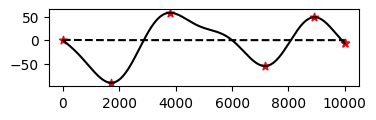

torch.Size([])
delta: 0.4972933530807495
13 extremas: [0, 0, 674, 1734, 2779, 3803, 4815, 5820, 6814, 7798, 8780, 9998, 9998]
2 drop [0, 9998]
11 selected: [0, 674, 1734, 2779, 3803, 4815, 5820, 6814, 7798, 8780, 9998]


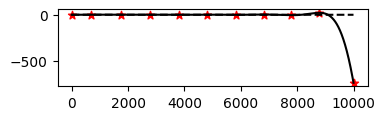

torch.Size([])
delta: 0.497706800699234


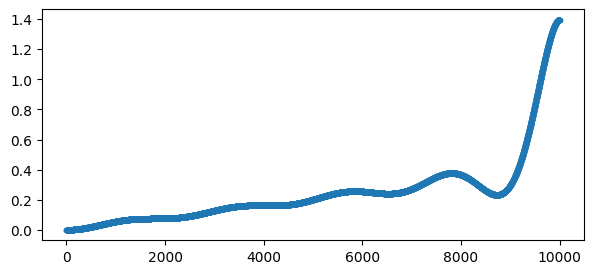

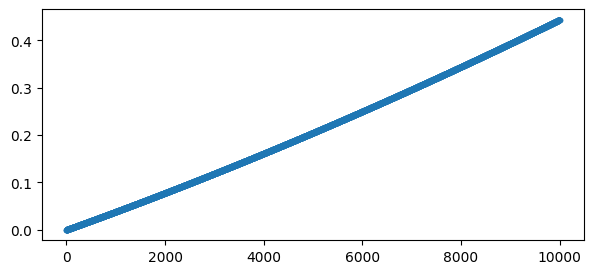

In [28]:
Ts = 0.75
M = 10000 # no of samples in [k*Ts, (k+1)*Ts]
N = 10 # no. polynomial params

CP = CosPoly(N)

y0 = torch.tensor(0.0)
y0_gt = torch.tensor(0.0)

for i,k in enumerate(range(0,1)):
    print(f'\n{k=}')
    t = torch.arange(k*Ts+Ts/M, (k+1)*Ts, Ts/M)

    for itr in range(1,3):

        # print(f'\n{itr=}')

        y_samples = CP.y(y0,t)

        y_t_samples = CP.y_t(t)
        f_samples = f(y_samples.reshape(-1,1), t.reshape(-1,1))
        d =  y_t_samples - f_samples

        extr_ind = find_extrema_alt_sign(d, N+1)

        plt.figure(figsize=(4,1))
        plt.plot(y_t_samples,'k')
        plt.plot(f_samples,'k--')
        plt.scatter(extr_ind, y_t_samples[extr_ind], marker='*', color='r')
        plt.show()
        plt.pause(0.5)

        if len(extr_ind) != N+1:
            extr_ind = torch.arange(0,M,M/(N+1)).tolist()

        print(f(y0,t).shape)
        CP.fit(t[extr_ind], y0)

    y_odeint = torchdiffeq.odeint(f, y0_gt.unsqueeze(0), t=t).squeeze()

    if i == 0:
        y_traj = CP.y(y0,t)
        y_traj_gt = y_odeint
    else:
        y_traj = torch.cat((y_traj, CP.y(y0,t)),0)
        y_traj_gt = torch.cat((y_traj_gt, y_odeint),0)

    y0 = y_traj[-1]
    y0_gt = y_traj_gt[-1]

plt.figure(figsize=(7,3))
plt.plot(y_traj,'.')
plt.figure(figsize=(7,3))
plt.plot(y_traj_gt,'.')

In [17]:
f(y0,t)

tensor(0.5000)

# N-D solve each 1-D separetely

In [ ]:
k = 0;
Ts = 1;
M = 10000; # no of samples in [k*Ts, (k+1)*Ts]
t = torch.arange(k*Ts,(k+1)*Ts,Ts/M) # dense time sampling
N = 10 # no. polynomial params
D = 2

CPs = [CosPoly(N) for _ in range(D)]

extr_ind = torch.arange(0,M,M/(N+1)).tolist()

for itr in range(1,10):

    print(f'\n{itr=}')

    for CP in CPs:
        y_samples = CP.y(t)
        y_t_samples = CP.y_t(t)
        f_samples = f(y_samples.reshape(-1,1), t.reshape(-1,1))
        d =  y_t_samples - f_samples

        # extr_ind = find_extrema_alt_sign(d, N+1)

        # plt.figure(figsize=(15,2))
        # plt.subplot(1,3,1)
        # plt.plot(torch.log(torch.abs(d)),'k')
        # # plt.plot(y_t_samples,'k')
        # # plt.plot(f_samples,'k--')
        # plt.plot(torch.zeros(len(t)),'k--')
        # # plt.scatter(extr_ind, d[extr_ind], marker='*', color='r')
        # # plt.legend(['','y_t-f','extrema','drop extr'])
        # plt.subplot(1,3,3)
        # plt.plot(torch.arange(0,1,1/100),f(torch.arange(0,1,1/100),1))
        # plt.subplot(1,3,2)
        # plt.stem(CP.a)

        # plt.show()
        # plt.pause(0.5)
        if len(extr_ind) != N+1:
            print('Incorrect number of extremas')
            break
        else:
            CP.fit(t[extr_ind], f_samples[extr_ind], CP.y(torch.tensor(k*Ts)))

#### Fixed Point Iteration Notes

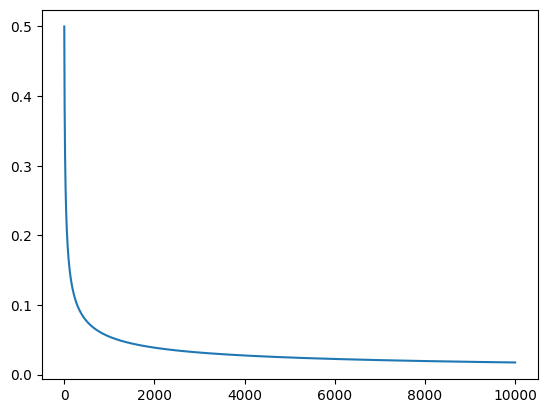

In [ ]:
Ax = 0.5
import numpy as np
out = []
for i in range(10000):
    out.append(x)
    x = np.sin(x)
plt.plot(out)

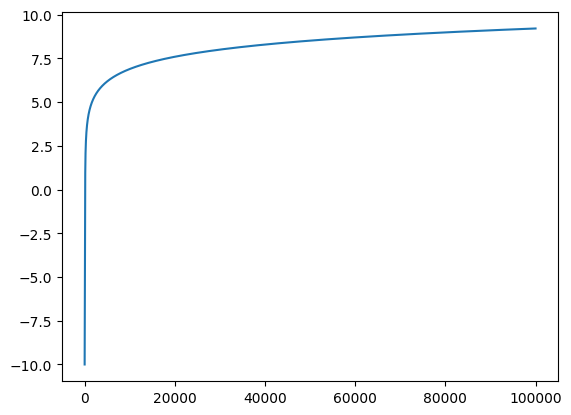

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
def f(x):
    return 1/(1+np.exp(x))
    # return np.cos(x)
    # return(1/(1+x))

def f_y(x):
    return f(x)*(1-f(x))
    # return -np.sin(x)
    # return -1/np.power(1+x,2)

delta = .1
y = [-10]
for _ in np.arange(100000):
    y0 = y[-1]
    y.append(y0 + delta*f(y0) + np.power(f_y(y0),2)*np.power(delta,2))

plt.plot(y)